In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

COLORS = sns.color_palette()

np.random.seed(3)

### MNIST Classification -- adversarial examples

_Copy of the MNIST notebook plus small experiment on adversarial examples. If we find good results we can move this stuff in the MNIST visualization notebook._

In [2]:
n_max_train = 30000
batch_size = 256
test_batch_size = 256


transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

class SubMNIST(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        idx = list(range(super().__len__()))
        self.idx = np.random.choice(idx, size=n_max_train, replace=False)
            
    def __len__(self):
        return len(self.idx)
    
    def __getitem__(self, index):
        idx = self.idx[index]
        return super().__getitem__(idx)
            
    
if n_max_train is not None:
    train_cls = SubMNIST
else:
    train_cls = datasets.MNIST
    
train_dataset = train_cls('data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True,transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_batch_size, shuffle=True, **kwargs)

n_classes = 10
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of testing examples: {len(test_loader.dataset)}")

Number of training examples: 30000
Number of testing examples: 10000


In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, dropout=0):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2), nn.Dropout2d(dropout), nn.LeakyReLU(),
            nn.Conv2d(16, 32, 5, stride=2), nn.Dropout2d(dropout), nn.LeakyReLU(),
        )
        self.fcs = nn.Sequential(
            nn.Linear(4*4*32, 128), nn.Dropout(dropout), nn.LeakyReLU(),
            nn.Linear(128, n_out), nn.Dropout(dropout), nn.LeakyReLU(),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        return self.fcs(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self, deterministic=False):
        super().__init__()
        self.deterministic = deterministic

    def forward(self, mu_q, cholesky):
        if self.deterministic:
            return mu_q
        else:
            eps = torch.randn_like(mu_q)
            return mu_q + eps @ cholesky
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        if not self.deterministic:
            kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
            #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
            return kl.sum()
        else:
            return 0.

class BayesianClassifier(nn.Module):
    def __init__(self, n_classes, last_layer_size, deterministic=False, dropout=0):
        super().__init__()
        self.features = FeaturesExtractor(n_out=last_layer_size, dropout=dropout)
        self.stochastic = CovarianceStochasticLayer(deterministic)
        
        self.n_classes = n_classes
        self.last_layer_size = last_layer_size
        self.a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
        self.a_size = np.prod(self.a_shape)
        self.b_size = n_classes
        n_parameters = self.a_size + self.b_size
        
        self.mu_ab = nn.Parameter(torch.zeros((n_parameters)))
        self.logvar_ab = nn.Parameter(-3 * torch.ones((n_parameters)))
        self.cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.01)
        
    def forward(self, x, t, n_samples=1):
        mu_ab = self.mu_ab
        logvar_ab = self.logvar_ab
        cov_ab_params = self.cov_ab_params
        batch_size = x.size(0)
        h = self.features(x)
        cov_ab = flat_to_triangular(cov_ab_params)

        # sample n_samples times a and b
        mu = self.mu_ab.unsqueeze(0).expand(n_samples, -1)
        L = make_cholesky(logvar_ab, cov_ab)
        ab_sample = self.stochastic(mu, L) 
        a, b = ab_sample[:, :-self.b_size], ab_sample[:, -self.b_size:]

        # reshape into [n_samples, *]
        a = a.unsqueeze(1).view(-1, *self.a_shape)
        b = b.unsqueeze(1)

        # compute y of size [n_samples x batch_size x n_classes]
        y = h @ a + b   # stochasticity here only comes from a and b

        # extend t and flatten 
        t = t.unsqueeze(0).expand(n_samples, batch_size)
        t = t.contiguous().view(-1)
        y = y.contiguous().view(-1, self.n_classes)

        # Reconstruction loss, estimated by MC
        recons = f.cross_entropy(y, t, reduction='none')
        recons = recons.view(n_samples, batch_size)

        # Accuracy
        y = y.view(n_samples, batch_size, self.n_classes)
        t = t.view(n_samples, batch_size)
        pred_class = torch.max(y.detach(), dim=2)[1]   # tensor of indices
        acc = torch.mean((t==pred_class).float(), 0)

        # KL loss, both analytic and by MC
        kl = self.stochastic.get_kl(mu_ab, logvar_ab, L)

        # compute elbo and view as [n_samples x batch_size]
        elbo = - recons - kl 
        elbo = elbo.view(n_samples, batch_size)
        
        return {'elbo':elbo, 'accuracy':acc, 'y':y, 'nll': recons, 'kl':kl}
        

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deterministic = False
dropout = 0.5
last_layer_size = 64
n_classes = 10
model = BayesianClassifier(n_classes, last_layer_size, deterministic=deterministic, dropout=dropout)
model.to(device)

N_train = len(train_loader.dataset)
N_test = len(test_loader.dataset)
N_train_batch = N_train // batch_size

l_rate = 1e-3
epochs = 500
n_samples = 10  # MC samples per example

optimiser = torch.optim.Adam(list(model.parameters()), lr = l_rate)
    
test_accs, test_logp, test_steps = [], [], []
step = 0
for epoch in range(1, epochs + 1):
    for batch_idx, (x, t) in enumerate(train_loader):
        model.train()
        x, t = x.to(device), t.to(device)
        optimiser.zero_grad()
        
        data = model(x, t, n_samples=n_samples)#) if not deterministic else 1)
        elbo = data.get('elbo')
        recons = data.get('nll')
        kl = data.get('kl')
        acc = data.get('accuracy')

        # IW averaging
        elbo = - recons.mean(0).sum() - kl / float(N_train_batch)
        # elbo = log_sum_exp(elbo, dim=0, sum_op=torch.mean)

        loss = - elbo
        loss.backward()
        optimiser.step()
        step += 1
        if step % 50 == 0:
            print(f'Epoch {epoch}  step {step} : loss {loss.item():.3f} ELBO {elbo.item():.3f}  NLL '
                  f'{recons.mean().item():.3f}  KL {kl/N_train:.3f}   acc {acc.mean().item():.3f}  Avg. Elbo {elbo/N_train:.3f}')
            
        if step % 100 == 0:
            model.train()
            with torch.no_grad():
                reconss = []
                accs = []
                for x, t in test_loader:
                    x, t = x.to(device), t.to(device)
                    data = model(x, t)
                    elbo = data.get('elbo')
                    recons = data.get('nll')
                    kl = data.get('kl')
                    acc = data.get('accuracy')
                    reconss += [recons]
                    accs += [acc]
                reconss = torch.cat(reconss, 1)
                acc = torch.cat(accs, 0).mean().item()
                logp = - log_sum_exp(reconss, dim=0, sum_op=torch.mean).sum().item()
                print(f"TEST epoch {epoch} step {step} : logp {logp:.3f} Accuracy: {acc:.3f} Avg. logp {logp/N_test:.3f}")
                test_accs += [acc]
                test_logp += [logp]
                test_steps += [step]

                with open(f"mnist-covariance{('-deterministic' if deterministic else '')}{('-dropout' if dropout > 0 else '')}.txt", 'w') as fi:
                    for i,acc,logp in zip(test_steps, test_accs, test_logp):
                        fi.write(f"{i},{acc},{logp}\n")
                          
                path = f"mnist-covariance{('-deterministic' if deterministic else '')}{('-dropout' if dropout > 0 else '')}.pt"
                torch.save(model, path)

Epoch 1  step 50 : loss 599.218 ELBO -599.218  NLL 2.318  KL 0.022   acc 0.102  Avg. Elbo -0.020
Epoch 1  step 100 : loss 598.322 ELBO -598.322  NLL 2.315  KL 0.022   acc 0.104  Avg. Elbo -0.020
TEST epoch 1 step 100 : logp -23160.439 Accuracy: 0.103 Avg. logp -2.316


/anaconda3/envs/venv-py3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BayesianClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/venv-py3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeaturesExtractor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/venv-py3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CovarianceStochasticLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2  step 150 : loss 597.572 ELBO -597.572  NLL 2.312  KL 0.022   acc 0.137  Avg. Elbo -0.020
Epoch 2  step 200 : loss 549.961 ELBO -549.961  NLL 2.126  KL 0.023   acc 0.231  Avg. Elbo -0.018
TEST epoch 2 step 200 : logp -20898.059 Accuracy: 0.251 Avg. logp -2.090
Epoch 3  step 250 : loss 401.913 ELBO -401.913  NLL 1.547  KL 0.023   acc 0.465  Avg. Elbo -0.013
Epoch 3  step 300 : loss 303.388 ELBO -303.388  NLL 1.161  KL 0.024   acc 0.588  Avg. Elbo -0.010
TEST epoch 3 step 300 : logp -12095.143 Accuracy: 0.581 Avg. logp -1.210
Epoch 3  step 350 : loss 274.141 ELBO -274.141  NLL 1.047  KL 0.024   acc 0.645  Avg. Elbo -0.009
Epoch 4  step 400 : loss 263.377 ELBO -263.377  NLL 1.005  KL 0.024   acc 0.666  Avg. Elbo -0.009
TEST epoch 4 step 400 : logp -8268.402 Accuracy: 0.730 Avg. logp -0.827
Epoch 4  step 450 : loss 187.613 ELBO -187.613  NLL 0.708  KL 0.024   acc 0.783  Avg. Elbo -0.006
Epoch 5  step 500 : loss 128.269 ELBO -128.269  NLL 0.476  KL 0.025   acc 0.854  Avg. Elbo -0.00

KeyboardInterrupt: 

### Test performances

In [ ]:
import pandas as pd
dropout = 0
deterministic = False
bayesian_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}.txt", names=['step','accuracy', 'elbo'])
                            
deterministic = True
ml_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}.txt", names=['step','accuracy', 'elbo'])
     
dropout = 0.5
deterministic = False
drop_bayesian_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}{('-dropout' if dropout > 0 else '')}.txt", names=['step','accuracy', 'elbo'])
                            
deterministic = True
drop_ml_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}{('-dropout' if dropout > 0 else '')}.txt", names=['step','accuracy', 'elbo'])
           
plt.figure(figsize=(21, 12))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(bayesian_data['step'], bayesian_data['accuracy'], label='Bayesian model', color=COLORS[0])
plt.plot(ml_data['step'], ml_data['accuracy'], label='ML model', color=COLORS[1])
plt.legend()
plt.ylim([0.5, 1])
          
plt.subplot(1,2,2)        
plt.title("log p")
plt.plot(bayesian_data['step'], bayesian_data['elbo'], label='Bayesian model')
plt.plot(ml_data['step'], ml_data['elbo'], label='ML model')
plt.legend()
#plt.ylim([-5000, 0])
plt.show()

## Adding Dropout to the features

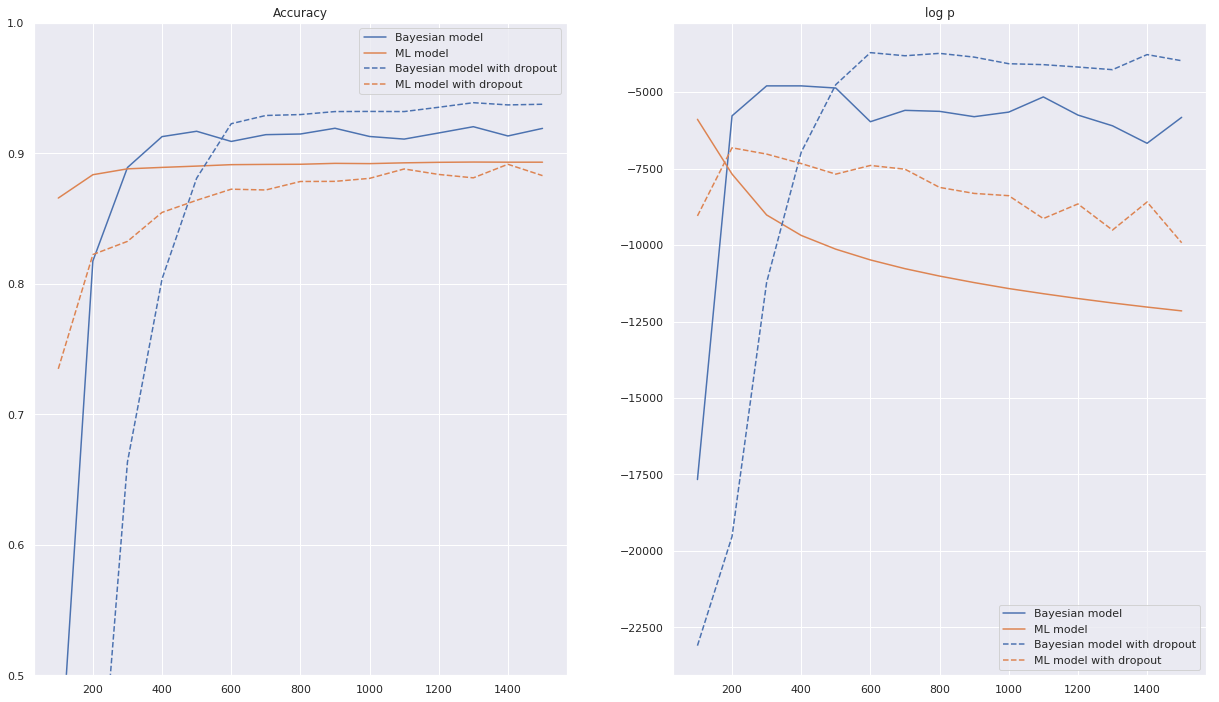

In [6]:
plt.figure(figsize=(21, 12))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(bayesian_data['step'], bayesian_data['accuracy'], label='Bayesian model', color=COLORS[0])
plt.plot(ml_data['step'], ml_data['accuracy'], label='ML model', color=COLORS[1])
plt.plot(drop_bayesian_data['step'], drop_bayesian_data['accuracy'], '--', label='Bayesian model with dropout', color=COLORS[0])
plt.plot(drop_ml_data['step'], drop_ml_data['accuracy'], '--', label='ML model with dropout', color=COLORS[1])
plt.legend()
plt.ylim([0.5, 1])
          
plt.subplot(1,2,2)        
plt.title("log p")
plt.plot(bayesian_data['step'], bayesian_data['elbo'], label='Bayesian model')
plt.plot(ml_data['step'], ml_data['elbo'], label='ML model')
plt.plot(drop_bayesian_data['step'], drop_bayesian_data['elbo'], '--', label='Bayesian model with dropout', color=COLORS[0])
plt.plot(drop_ml_data['step'], drop_ml_data['elbo'], '--', label='ML model with dropout', color=COLORS[1])
plt.legend()
#plt.ylim([-5000, 0])
plt.show()

## Adversarial attacks

See how easy it is to find adversarial examples by minimizing probability of true class wrt input.

Very random code for now, just to see how it could work. Tried with models not fully trained to convergence. With ML model it's super easy to find adversarial examples and they look like the original. With Bayesian it seems to be harder, and when the target class prob is low enough the input actually looks a bit different from the original, usually. We can still find adversarial examples though.

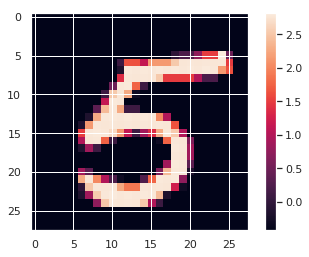

classified correctly: True
logits: ['0.40', '-11.78', '-6.80', '1.98', '-5.62', '14.14', '-0.94', '-2.82', '-1.94', '-3.45']
probs:['0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00']


In [61]:
# Get a test batch, whatever
x, t = test_loader.__iter__().__next__()

# Choose an index
example_index = 3
X = x[example_index].unsqueeze(0)
T = t[example_index].unsqueeze(0)
X = X.requires_grad_()
X_backup = X.clone()
Y_dict = model(X, T)
plt.imshow(X[0, 0].detach().numpy())
plt.colorbar()
plt.show()
print('classified correctly:', bool(Y_dict['accuracy']))
Y = Y_dict['y']
print('logits:', str(['{:.2f}'.format(value) for value in Y[0, 0].cpu().detach().numpy()]))
print('probs:' + str(['{:.2f}'.format(value) for value in Y.softmax(-1)[0, 0].cpu().detach().numpy()]))

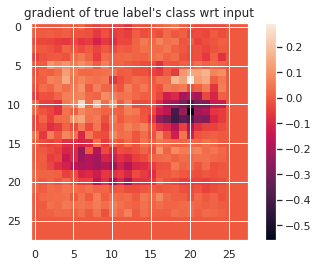

In [62]:
# sanity check

loss = Y[0, 0, T]
loss.backward()

plt.imshow(X.grad[0, 0].detach().numpy())
plt.colorbar()
plt.title("gradient of true label's class wrt input")
plt.show()


### Get adversarial example

In Bayesian case it can be very unstable bc of sampling from posterior $q(w)$, so we take many MC samples, show the average logits for the same input but for different sampled weights, and also optimize wrt this average so the gradient is stable.

['0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000']


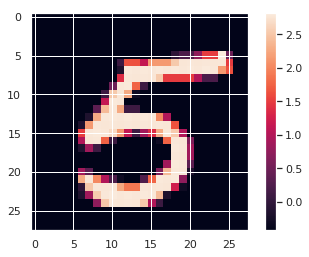

['0.001', '0.000', '0.000', '0.004', '0.000', '0.995', '0.000', '0.000', '0.000', '0.000']


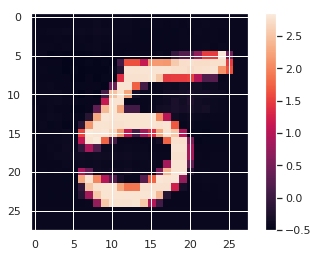

['0.001', '0.000', '0.000', '0.002', '0.000', '0.996', '0.000', '0.000', '0.000', '0.000']


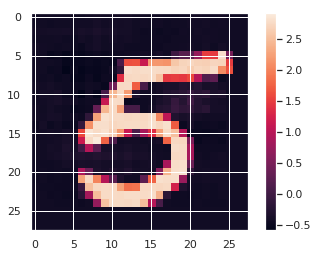

['0.003', '0.000', '0.000', '0.005', '0.000', '0.990', '0.000', '0.000', '0.001', '0.000']


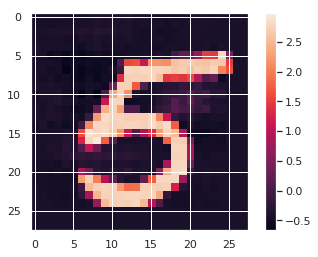

['0.009', '0.000', '0.001', '0.016', '0.000', '0.967', '0.002', '0.002', '0.003', '0.001']


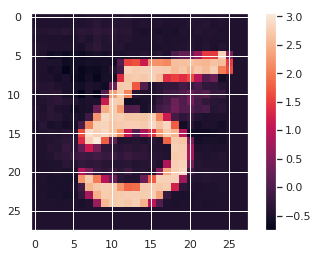

['0.021', '0.001', '0.002', '0.043', '0.001', '0.901', '0.006', '0.005', '0.013', '0.006']


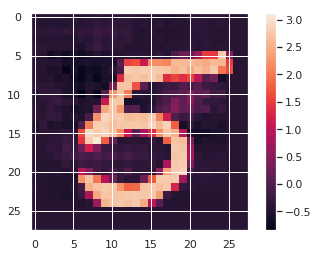

['0.031', '0.003', '0.007', '0.068', '0.005', '0.816', '0.012', '0.010', '0.032', '0.016']


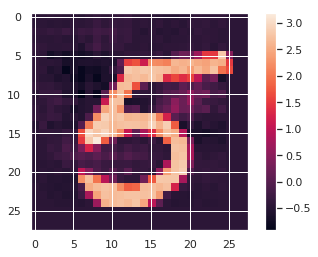

['0.041', '0.006', '0.017', '0.091', '0.008', '0.684', '0.020', '0.018', '0.080', '0.034']


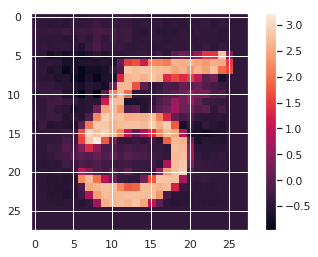

['0.045', '0.012', '0.034', '0.115', '0.017', '0.447', '0.025', '0.035', '0.214', '0.056']


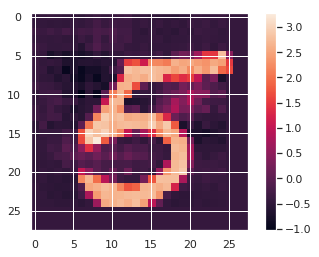

['0.024', '0.015', '0.034', '0.084', '0.017', '0.278', '0.018', '0.032', '0.444', '0.054']


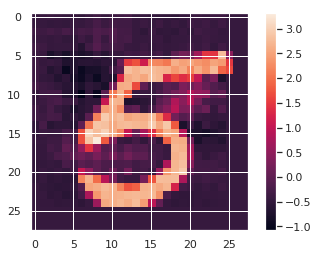

['0.017', '0.017', '0.039', '0.077', '0.015', '0.175', '0.016', '0.032', '0.559', '0.053']


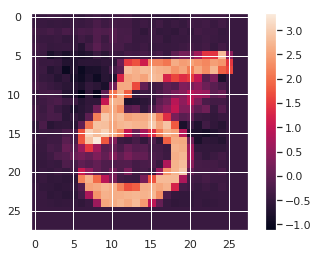

['0.017', '0.020', '0.042', '0.080', '0.017', '0.145', '0.016', '0.033', '0.575', '0.056']


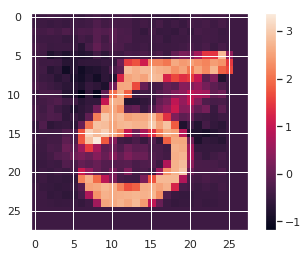

['0.017', '0.018', '0.052', '0.076', '0.015', '0.139', '0.013', '0.032', '0.581', '0.057']


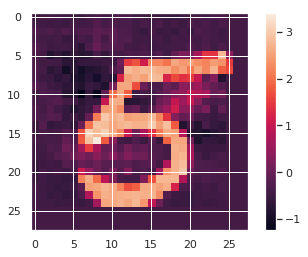

['0.017', '0.021', '0.063', '0.102', '0.017', '0.094', '0.014', '0.038', '0.570', '0.063']


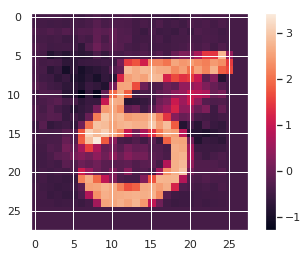

['0.016', '0.025', '0.054', '0.077', '0.018', '0.104', '0.013', '0.030', '0.611', '0.051']


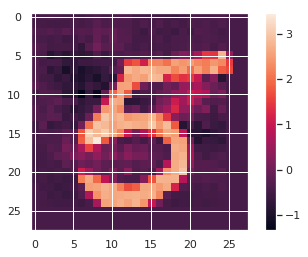

In [65]:
model.eval()
X = X_backup.detach().clone().requires_grad_()
n_samples = 20   # draw many samples for the nondeterministic case, then take average of logits (over posterior q(w))
adv_optimizer = torch.optim.SGD([X], lr=5e-2)
for i in range(150):
    adv_optimizer.zero_grad()
    Y_dict = model(X, T, n_samples=n_samples)
    Y = Y_dict['y']
    loss = Y[:, 0, T].mean(0)
#     loss = -Y[:, 0, 1].mean(0)   # increase score of target class
    loss.backward()
    if i+1 % 10 == 0:
        print(['{:.3f}'.format(value) for value in Y.softmax(-1)[:, 0].mean(0)])
        plt.imshow(X[0, 0].detach().numpy())
        plt.colorbar()
        plt.show()
    adv_optimizer.step()

### Get adversarial example with target class

['0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000']


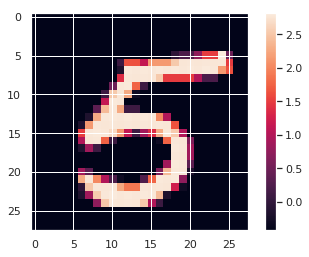

['0.001', '0.000', '0.000', '0.001', '0.000', '0.998', '0.000', '0.000', '0.000', '0.000']


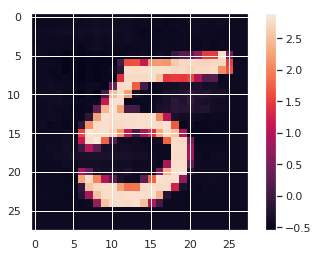

['0.005', '0.000', '0.000', '0.006', '0.000', '0.987', '0.000', '0.000', '0.001', '0.000']


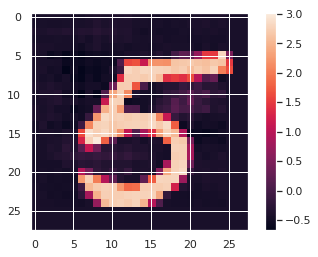

['0.021', '0.001', '0.003', '0.035', '0.001', '0.902', '0.009', '0.006', '0.016', '0.006']


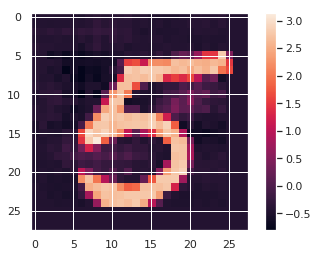

['0.018', '0.010', '0.029', '0.070', '0.009', '0.292', '0.019', '0.025', '0.495', '0.033']


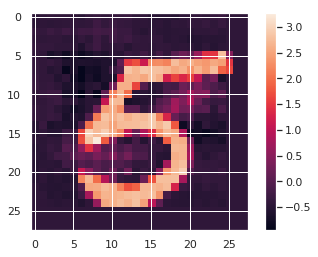

['0.006', '0.010', '0.027', '0.041', '0.005', '0.075', '0.007', '0.014', '0.793', '0.021']


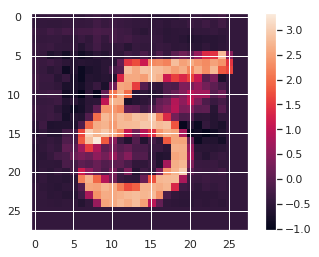

['0.001', '0.004', '0.015', '0.011', '0.001', '0.009', '0.001', '0.004', '0.947', '0.005']


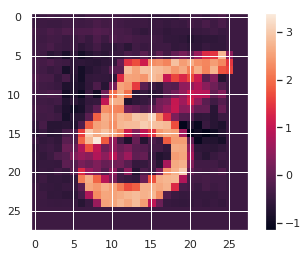

['0.000', '0.001', '0.003', '0.002', '0.000', '0.001', '0.000', '0.001', '0.991', '0.001']


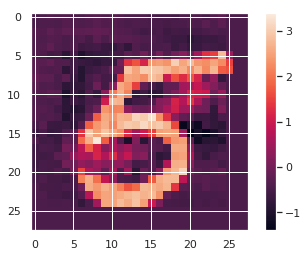

['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.999', '0.000']


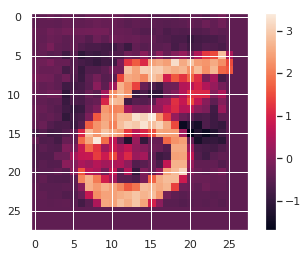

In [69]:
model.eval()
target_class = 8
X = X_backup.detach().clone().requires_grad_()
n_samples = 20   # draw many samples for the nondeterministic case, then take average of logits (over posterior q(w))
adv_optimizer = torch.optim.SGD([X], lr=1e-1)
for i in range(160):
    adv_optimizer.zero_grad()
    Y_dict = model(X, T, n_samples=n_samples)
    Y = Y_dict['y']
    loss = -Y[:, 0, target_class].mean(0)   # increase score of target class
    loss.backward()
    if i+1 % 20 == 0:
        print(['{:.3f}'.format(value) for value in Y.softmax(-1)[:, 0].mean(0)])
        plt.imshow(X[0, 0].detach().numpy())
        plt.colorbar()
        plt.show()
    adv_optimizer.step()